In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from utils import Processor, EnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import numpy as np
import pandas as pd
import telepot
%matplotlib inline

In [2]:
# os.chdir('/')
trainFid = 'KDDTrain+.txt'
testFid = 'KDDTest-21.txt'
bot = telepot.Bot('258510570:AAHujlmQqiZ_L4yrWMR9HtuE-0rK8xXo-XY')

## 資料前處理

In [3]:
traindata, attack_type_list = Processor.cleanData(trainFid)
traindata = traindata.iloc[np.random.permutation(len(traindata))]
test_data_len = 20000
traindata_len = len(traindata) - test_data_len
testdata = traindata[traindata_len:]
traindata = traindata[:traindata_len]
# testdata, _ = Processor.cleanData(testFid)
traindata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
103748,0,tcp,http,SF,235,1215,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
106557,0,tcp,ftp_data,SF,15377,0,0,0,0,0,...,48,0.29,0.02,0.29,0.04,0.00,0.00,0.00,0.0,0
122764,1,tcp,private,RSTR,0,0,0,0,0,0,...,2,0.01,0.12,0.22,0.00,0.01,0.00,0.44,1.0,3
123069,0,tcp,telnet,S0,0,0,0,0,0,0,...,39,0.66,0.03,0.02,0.00,0.97,0.95,0.00,0.0,1
2921,0,tcp,http,SF,270,1074,0,0,0,0,...,255,1.00,0.00,0.01,0.00,0.01,0.01,0.00,0.0,0


##### 列出一些基本資料

In [4]:
print "攻擊型態：%s" % attack_type_list
print "有%d筆訓練資料" % len(traindata)
print "有%d筆測試資料" % len(testdata)

攻擊型態：['normal', 'dos', 'r2l', 'probe', 'u2r']
有105973筆訓練資料
有20000筆測試資料


##### 資料的特徵及屬性

In [5]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105973 entries, 103748 to 40134
Data columns (total 42 columns):
duration                       105973 non-null int64
protocol_type                  105973 non-null object
service                        105973 non-null object
flag                           105973 non-null object
src_bytes                      105973 non-null int64
dst_bytes                      105973 non-null int64
land                           105973 non-null int64
wrong_fragment                 105973 non-null int64
urgent                         105973 non-null int64
hot                            105973 non-null int64
num_failed_logins              105973 non-null int64
logged_in                      105973 non-null int64
num_compromised                105973 non-null int64
root_shell                     105973 non-null int64
su_attempted                   105973 non-null int64
num_root                       105973 non-null int64
num_file_creations             105

#### 1. 檢視攻擊種類分佈

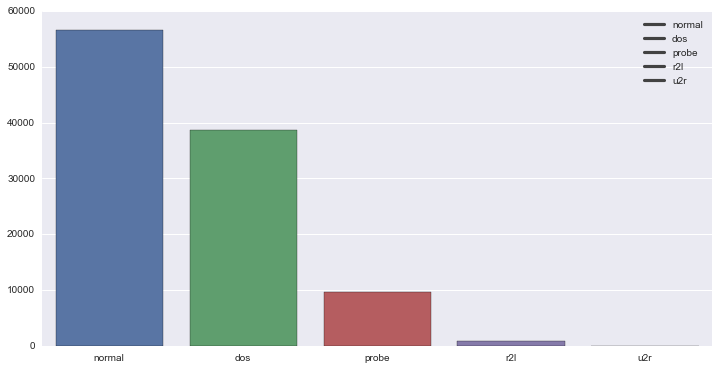

In [6]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(traindata['attack_type'].value_counts())), y=traindata['attack_type'].value_counts().tolist())
attack_t = [attack_type_list[i] for i in traindata['attack_type'].value_counts().index]
plt.legend(attack_t,loc=0)
ax.set_xticklabels(attack_t)

以攻擊型態來說，最常見的是DOS，其次是Probe，其餘兩個比較少見

#### 2. 資料標準化

In [7]:
data_all = pd.concat([traindata, testdata])
traindata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[:len(traindata)]
testdata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[len(traindata):]
traindata_df['attack_type'] = traindata['attack_type']
testdata_df['attack_type'] = testdata['attack_type']
anomalydata_df = traindata_df[traindata_df['attack_type']!=0]
anomalydata_df.index = range(0, len(anomalydata_df))
normaldata_df = traindata_df[traindata_df['attack_type']==0]
normaldata_df.index = range(0, len(normaldata_df))

###### 把異常和正常資料分離出來

In [8]:
normaldata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.110249,-0.007722,-0.004616,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.110249,-0.005143,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.110249,-0.007716,-0.004652,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,-0.110249,-0.007724,-0.004161,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.110249,-0.007754,-0.004901,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [9]:
anomalydata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.109865,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.110249,0.001529,-0.002851,-0.014089,-0.089486,-0.007736,0.835171,-0.027023,1.235689,0.030104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [10]:
testdata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
55695,0,tcp,private,RSTR,0,0,0,0,0,0,...,1,0.01,0.05,0.02,0.0,0.0,0.0,0.03,1.0,3
111653,0,tcp,http,SF,262,2539,0,0,0,0,...,255,1.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0
12743,0,udp,domain_u,SF,43,69,0,0,0,0,...,225,0.88,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0
20788,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.0,1.0,1.0,0.00,0.0,1
2736,0,tcp,klogin,S0,0,0,0,0,0,0,...,7,0.03,0.07,0.00,0.0,1.0,1.0,0.00,0.0,1


#### 3. 異常資料分群

In [11]:
K = 3 #分幾群
kmeans = KMeans(n_clusters=K, random_state=0).fit(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])
clustors = kmeans.predict(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])

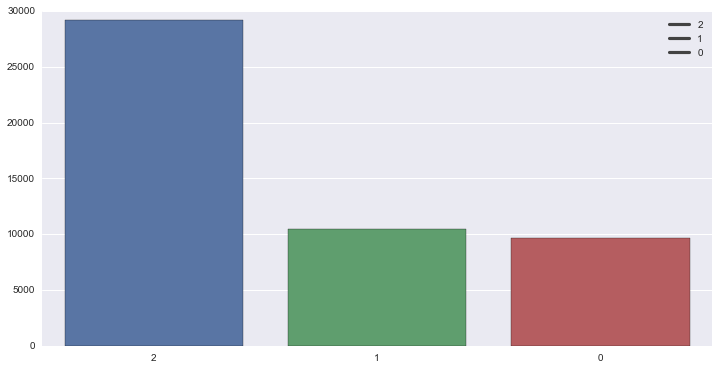

In [12]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(pd.Series(clustors).value_counts())), y=pd.Series(clustors).value_counts().tolist())
plt.legend(pd.Series(clustors).value_counts().index.tolist(),loc=0)
ax.set_xticklabels(pd.Series(clustors).value_counts().index.tolist())

有一群特別多，但還算是可接受的範圍

In [13]:
try:
    anomalydata_df = anomalydata_df.drop(['clusters'], axis = 1)
except:
    pass
anomalydata_df.insert(0, 'clusters', pd.Series(clustors, dtype=np.int64))

In [14]:
cluster_df = []
for cluster in sorted(anomalydata_df['clusters'].unique()):
    node = anomalydata_df[anomalydata_df['clusters']==cluster]
    node = node.drop(['clusters'], axis=1)
    cluster_df.append(node)

###### 檢視各群的攻擊型態分佈

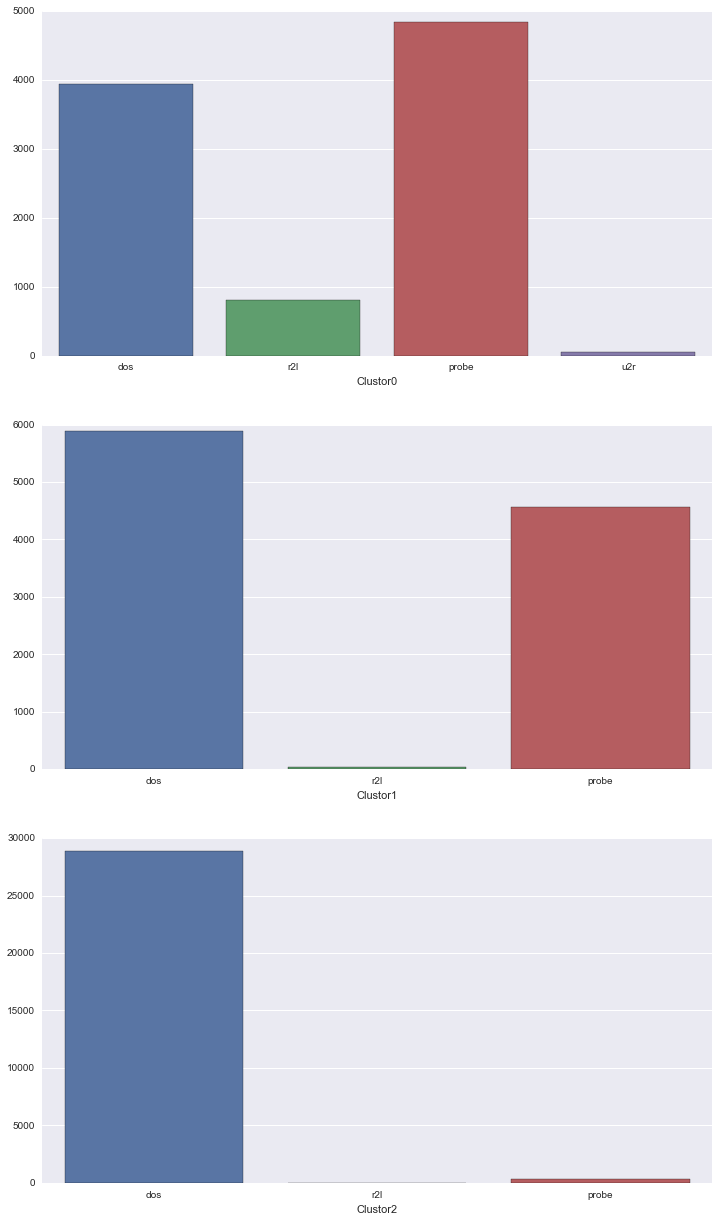

In [15]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

#### 4. 正常資料與異常合併

In [16]:
for index in range(0, len(cluster_df)):
    df = pd.concat([cluster_df[0], normaldata_df], ignore_index = True)
    cluster_df[index] = pd.concat([cluster_df[index], normaldata_df], ignore_index = True)
    cluster_df[index] = cluster_df[index].iloc[np.random.permutation(len(cluster_df[index]))]
    cluster_df[index].index = range(0, len(cluster_df[index]))

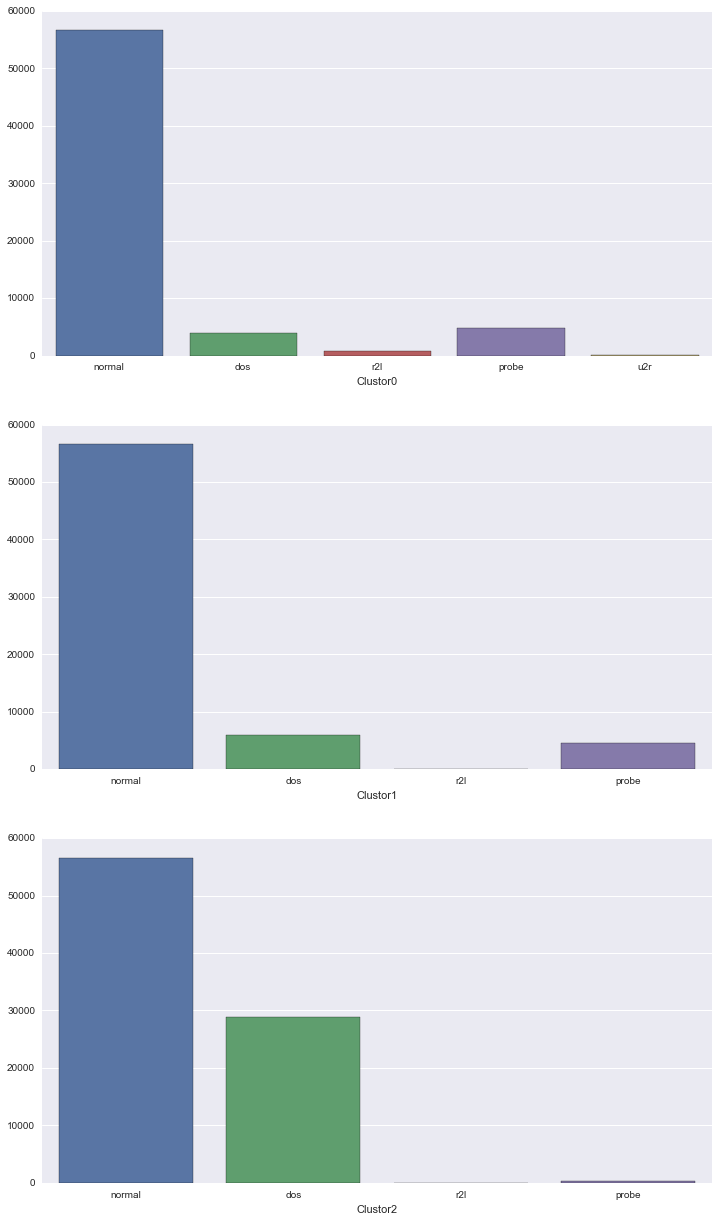

In [17]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts().sort_index()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

## 針對資料進行學習

In [18]:
traindata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
103748,-0.110249,-0.007722,-0.004616,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
106557,-0.110249,-0.005143,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
122764,-0.109865,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
123069,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2921,-0.110249,-0.007716,-0.004652,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [19]:
testdata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
55695,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
111653,-0.110249,-0.007718,-0.004287,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,1.235689,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
12743,-0.110249,-0.007755,-0.004901,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
20788,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2736,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,-0.027023,-0.809259,-0.011664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


###### 衡量方法 - 利用混淆矩陣

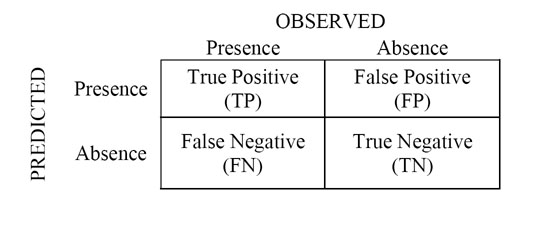

In [20]:
from IPython.display import Image
Image(filename='img/tpfpfntn.jpg')

$$Recall = \frac{TN}{TN+FN}$$

In [21]:
def score(m):
    tp = m[0][0]
    fp = m[0][1]
    fn = m[1][0]
    tn = m[1][1]
    recall = 1. * tn / (tn + fp)
    accuracy = float(tp + tn) / (tp + fp + tn + fn)
    
    return accuracy, recall
def plot_confusion_matrix(cm, title='Confusion Metrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(0, 2)
    plt.xticks(tick_marks, ['normal', 'anomaly'], rotation=45)
    plt.yticks(tick_marks, ['normal', 'anomaly'])
    plt.tight_layout()
    plt.grid(False)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

#### 1. 最簡單的分類器
新增一個對照組 (利用貝氏定理)

LogisticRegression分類器 準確度：0.984250
LogisticRegression分類器 recall：0.980722


GaussianNB分類器 準確度：0.706750
GaussianNB分類器 recall：0.811739


DecisionTreeClassifier分類器 準確度：0.998150
DecisionTreeClassifier分類器 recall：0.998923




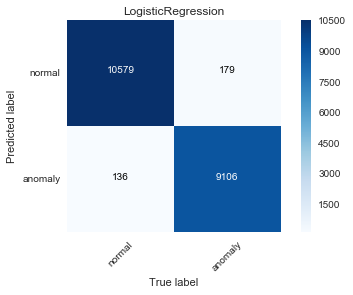

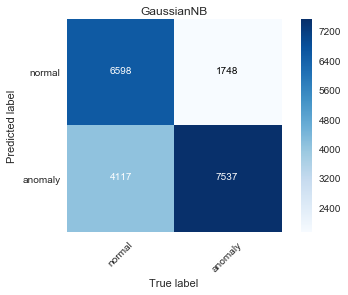

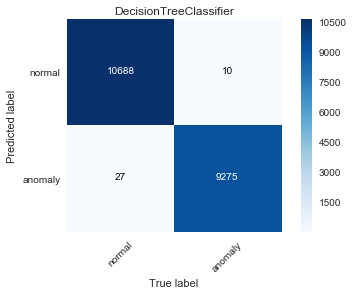

In [22]:
train_x = traindata_df.drop(['attack_type'], axis = 1).values
train_y = traindata_df['attack_type'].values
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
answer = np.array([0 if a == 0 else 1 for a in answer])

clfs = [
    LogisticRegression(),
    GaussianNB(),
    DecisionTreeClassifier()
]

for index, clf in enumerate(clfs):
    clf.fit(train_x, train_y)
    predict = clf.predict(test_x)
    predict = np.array([0 if p == 0 else 1 for p in predict])
    cfu_metrix = metrics.confusion_matrix(answer, predict).T
    accuracy, recall = score(cfu_metrix)

    print "%s分類器 準確度：%f" % (str(type(clf).__name__), accuracy)
    print "%s分類器 recall：%f" % (str(type(clf).__name__), recall)
    print '\n'

    plt.figure()
    plot_confusion_matrix(cfu_metrix, str(type(clf).__name__))

###### 分層訓練

In [23]:
en_clf_list = []
for index in range(0, len(cluster_df)):
    clf_cluster = [
        RandomForestClassifier(),
        AdaBoostClassifier(n_estimators=200),
        BaggingClassifier(n_estimators=30)
    ]
    
    train_y = cluster_df[index]['attack_type'].values
    train_x = cluster_df[index].drop(['attack_type'], axis = 1).values
    
    en = EnsembleClassifier(clf_cluster)
    en.fit(train_x, train_y)
    en_clf_list.append(en)

###### 分層預測

In [24]:
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
prediction = []
normal_index = []

for index in range(0, len(en_clf_list)):
    predict = en_clf_list[index].predict(test_x)
    normal_index.append(np.where(predict == attack_type_list.index('normal'))[0])
    
    test_x = test_x[normal_index[index]]
    answer = answer[normal_index[index]]

In [25]:
answer = testdata_df['attack_type'].values
pre = normal_index[0][normal_index[1][normal_index[2]]]
predict = []
for i in range(0, len(answer)):
    if i in pre:
        predict.append(attack_type_list.index('normal'))
    else:
        predict.append(1)
predict = np.array(predict)
answer = np.array([0 if a == 0 else 1 for a in answer])

##### 經過多層次分類器預測後的準確機率

準確度：0.998700
recall：0.997523


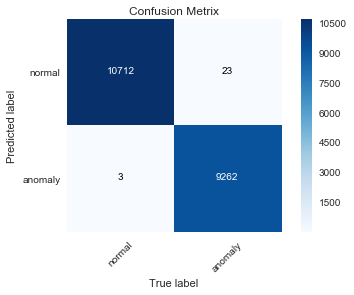

In [26]:
# 預測準確的資料長度 / 測試資料的長度
cfu_metrix = metrics.confusion_matrix(answer, predict).T
accuracy, recall = score(cfu_metrix)

print "準確度：%f" % accuracy
print "recall：%f" % recall
plt.figure()
plot_confusion_matrix(cfu_metrix)

In [27]:
bot.sendMessage('252175743', '多層次分類器運算完了')

{u'chat': {u'first_name': u'\u9673',
  u'id': 252175743,
  u'last_name': u'\u9347\u5609',
  u'type': u'private',
  u'username': u'kaijia'},
 u'date': 1479044284,
 u'from': {u'first_name': u'kaijiabot',
  u'id': 258510570,
  u'username': u'kaijia_bot'},
 u'message_id': 27,
 u'text': u'\u591a\u5c64\u6b21\u5206\u985e\u5668\u904b\u7b97\u5b8c\u4e86'}